In [1]:
## Use this parcel if you want to FULLY automate your python script
## for more infor, please reach to IBC
## link: https://github.com/IbcAlpha/IBC
## this parcel will automatically open and log in your IB account
from subprocess import Popen
p = Popen('StartTWS.bat',cwd = r"C:\IBC", shell = True)
stdout, stderr = p.communicate()

import time
time.sleep(10)
print("sleeping 10 seconds")

sleeping 10 seconds


In [2]:
#from IPython.core.debugger import set_trace

In [3]:
#import pairs_backtest as pb
import datetime as dt #in-built module
import pandas as pd
from pandas_datareader import data
import yfinance as yf
from yahoo_fin import stock_info as si
import matplotlib.pyplot as plt
from matplotlib import style
from pathlib import Path
import os
from tqdm import tqdm   
import glob
import datetime as dt
from pandas_datareader import data as pdr

from pairs_backtest import kalman_lib as kalman
from pairs_backtest import find_pairs
from pairs_backtest import utils
import ib_insync 
ib_insync.util.startLoop()  # only use in interactive environments (i.e. Jupyter Notebooks)


def delete_folder_contents(folder_path):
    # Iterate over all the items in the folder
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)

        # Check if the item is a file
        if os.path.isfile(item_path):
            # Delete the file
            os.remove(item_path)
        # Check if the item is a subfolder
        elif os.path.isdir(item_path):
            # Recursively delete the subfolder and its contents
            delete_folder_contents(item_path)
            # Delete the empty subfolder
            os.rmdir(item_path)
            

class ib_pt ():
    def __init__(self, backtest_day, len_constrain_day, start_date, end_date, coint_pairs_type,capital,no_paris, connect_to_ib = True):
        self.backtest_day = backtest_day
        self.len_constrain_day = len_constrain_day
        date = dt.datetime.now()
        self.today = '%s_%s_%s'%(date.year,date.month,date.day)
        self.start = start_date
        self.end = end_date
        self.capital = capital
        self.coint_pairs_type = coint_pairs_type
        self.holding_pairs = []
        self.df = []
        self.first_inst = []
        self.second_inst = []
        self.no_pairs = no_paris
        self.init()
        if connect_to_ib:
            print('Selected to online mode')
            self.ib = self.run_ib()
        else:
            print('Selected to offline mode')
            self.ib = False
            
       
    def init(self):
        if not os.path.exists('log'):
            os.makedirs('log')
        if not os.path.exists('pairs_data'):
           os.makedirs('pairs_data')
        if not os.path.exists('Changing'):
           os.makedirs('Changing')
        if not os.path.exists('trades'):
           os.makedirs('trades')  
        dir = 'py_plot'
        for f in os.listdir(dir):
          os.remove(os.path.join(dir, f))

    def read_local_all_holding(self):
        try:
            local_holding = pd.read_csv('trades/local_all_holding.csv', columns = ['symbol','position','avgCost']) 
        except:
            local_holding = "Empty"
        return  local_holding      

    
    def load_existing_pairs_csv (self, type = 'last_result', head = 1000):
        #date = dt.datetime.today().strftime('%Y_%m_%d')
        if os.path.isfile("pairs_%s.csv"%self.today): #if file exists
          df = pd.read_csv("pairs_%s.csv"%self.today)
          return df
        elif type == 'allUS': # if file does not exist, find pairs
          print('selected allUS')
          df = find_pairs.get_US_allstock(lookback=self.backtest_day)
          print('All_US_STOCK',df)
          score_matrix, pvalue_matrix, pairs = find_pairs.find_cointegrated_pairs(df)
          print (pairs)
          #find_pairs.save_txt(pairs)  #save all the pairs
          df_pairs = pd.DataFrame(pairs, columns = ['s1','s2','p-value'])
          df_pairs = df_pairs.sort_values(by=['p-value']).head(head)
          df_pairs.to_csv("pairs_%s.csv"%self.today)
          return df_pairs
        elif type == 'last_result':
            csv_files_date = []
            csv_files = glob.glob(os.path.join(os.getcwd(), 'pairs*.csv')) #get all the csv file (e.g. pairs_yyyy_mm_dd)
            for csv_file in csv_files:
               filename = os.path.split(csv_file)[1]
               date = str(filename[6:-4])
               date = dt.datetime.strptime(date ,'%Y_%m_%d').date()
               csv_files_date.append(date)
            max_date = max(csv_files_date)
            latest_path = os.getcwd()+'\pairs_%s_%s_%s.csv'%(max_date.year,max_date.month,max_date.day)
            print('Latest path of existing pairs which passed cointegration test:',latest_path)
            df = pd.read_csv(latest_path,index_col=0)
            #print (df)
            return df
        else:
           raise Exception("Please specify 'TYPE'") 

    def get_position(self, save_to_csv = True): 
        position = self.ib.positions()
        position_list = []
        for item in position:
            dictionary = {'symbol':item.contract.symbol,
                        'position':item.position,
                        'avgCost':item.avgCost}
            position_list.append(dictionary)

        if save_to_csv:
            pd.DataFrame(position_list).to_csv('trades/local_all_holding.csv', index = False, header = True)
        return position_list
        
    
    def is_empty_pairs(self):
        holding_pairs= pd.read_csv('trades/holding_pairs.csv')
        if holding_pairs.empty:
            print('local holding is empty')
            return True
        else:
            self.holding_pairs = holding_pairs
            return False 
    
    def get_trades_in_IB(self):
        trades = self.ib.trades()
        return trades

    def load_latest_changing_pairs(self):
        directory = 'Changing'
        csv_files = glob.glob(os.path.join(directory, '*.csv'))
        csv_files_date = []
        #extract the date of the existing directory
        for csv_file in csv_files:
            filename = os.path.split(csv_file)[1]
            date = str(filename[15:-4])
            date = dt.datetime.strptime(date ,'%Y_%m_%d').date()
            csv_files_date.append(date)
    
        max_date = max(csv_files_date)
        # Get the latest CSV file
        latest_path = directory+'\changing_pairs_%s_%s_%s.csv'%(max_date.year,max_date.month,max_date.day)
        print('Latest path:',latest_path)
        df = pd.read_csv(latest_path,index_col=0)
        return df,max_date
    

    def find_changing_pairs(self,len_constrain_day = 365):
        '''
        Return: dataframe of the changing pairs
        '''
        delete_folder_contents('pairs_data')

        pairs = self.load_existing_pairs_csv(type = self.coint_pairs_type)
        df_changing_pairs = pd.DataFrame(columns =['first_stock','second_stock','from_date','from_signal','To_date','To_signal','Hedge Ratio'])
        for pair in tqdm(pairs.iterrows()):
            #print (pair)
            first_instrument = pair[1]['s1']
            second_instrument = pair[1]['s2']

            df_1 = self.get_data(first_instrument,self.start,self.end)
            df_2 = self.get_data(second_instrument,self.start,self.end)
            common_index = (df_1.index).intersection(df_2.index)
            df_1 = df_1.loc[common_index].copy()
            df_2 = df_2.loc[common_index].copy()
            if len(common_index) > len_constrain_day: ##length constraint
                df, sharpe, half_life = kalman.backtest(df_1['Adj Close'], df_2['Adj Close'])
                df = df.dropna()
                df = df[['x','y','hr','zScore','numUnits','cum rets']]
                df.to_csv('pairs_data/%s-%s.csv' % (first_instrument,second_instrument))
                self.df = df
                #find_changing_pairs:
                #changing_pairs = changing_pairs.append(utils.changing_pairs_dict(first_instrument,second_instrument,df = df), ignore_index = True)
                changing_pairs = utils.changing_pairs_dict(first_instrument,second_instrument,df = df)
                if changing_pairs is not None:
                    pairs_dict = pd.DataFrame.from_dict(changing_pairs,orient='index').T
                    df_changing_pairs= pd.concat([df_changing_pairs,pairs_dict], ignore_index = True)
                    kalman.py_plot(df,self.today,first_instrument,second_instrument)
        df_changing_pairs.to_csv('Changing/changing_pairs_%s.csv'%(self.today))
        return df_changing_pairs



    def get_data(self,code,start,end):
        #data = yf.Ticker(code)
        #data = data.history(start = start, end = end)
        #data.index = data.index.strftime('%d/%m/%Y')
        df=pdr.get_data_yahoo(code,start,end)
        return df
    
    def run_ib(self):
        id = 1
        flag = True
        ib = ib_insync.IB()
        while flag:
            try:
                ib.connect(host='127.0.0.1', port=4001, clientId=id, timeout = 5.0) #TWS
                #ib.connect(host='127.0.0.1', port=4002, clientId=id, timeout = 5.0) #Gateway
            except:
                ib.disconnect()
                print ("can't connect to IB API, now try to connect to another cllientID")
                id += 1
            else:
                print ("Connected to IB API")
                flag = False
                return ib
    
    def close_ib(self):
        self.ib.disconnect()
    
    def run_strategy(self):
        ib_position_list = self.get_position()
        is_empty_pairs = self.is_empty_pairs()
         
        if is_empty_pairs:
            self.find_changing_pairs()
            df,latest_date = self.load_latest_changing_pairs()
            can_trade = df[(df['To_signal']!=0)&(abs(df['Hedge Ratio'])>1)]
            if can_trade.empty:
                print ('Empty changing pair')
            else:
                first_row = can_trade.iloc[:self.no_pairs]
                dir = 'trades'
                for f in os.listdir(dir):
                    os.remove(os.path.join(dir, f))

                for i in range(self.no_pairs):           
                    x_stock = first_row['first_stock'][i]
                    self.first_inst = x_stock
                    y_stock = first_row['second_stock'][i]
                    self.second_inst = y_stock

                    ratio = abs(round(first_row['Hedge Ratio']))
                    x_df = self.get_data(x_stock,self.start,self.end)
                    y_df = self.get_data(y_stock,self.start,self.end)
                    common_index = (x_df.index).intersection(y_df.index)
                    if len(common_index) > self.len_constrain_day:
                        x_df = x_df.loc[common_index].copy()
                        y_df = y_df.loc[common_index].copy() 
                        df, sharpe, _ = kalman.backtest(x_df['Adj Close'], y_df['Adj Close']) #df1 = x; df2 = y
                        df = df.dropna()
                        df.to_csv('log/%s_%s.csv'%(x_stock,y_stock))
                        self.df = df

                        if first_row['To_signal']==1:
                            #Long second (y); Short first (x) * hedge ratio

                            one_unit_cost = df['x'][-1]*ratio+df['y'][-1] 
                            current_spread = df['y'][-1]  - df['x'][-1]*ratio
                            one_unit_quantity = round(self.capital/one_unit_cost)

                            x_contract = ib_insync.Stock(x_stock,exchange='SMART',currency='USD')
                            self.ib.qualifyContracts(x_contract)
                            x_contract_quantity = one_unit_quantity*ratio
                            order1 = ib_insync.MarketOrder('SELL', x_contract_quantity)
                            self.ib.placeOrder(x_contract, order1)
                            print('Placed: SELL %s %s'%(x_stock,x_contract_quantity))

                            y_contract = ib_insync.Stock(y_stock,exchange='SMART',currency='USD')
                            self.ib.qualifyContracts(y_contract)
                            y_contract_quantity = one_unit_quantity
                            order2 = ib_insync.MarketOrder('BUY', y_contract_quantity)
                            self.ib.placeOrder(y_contract, order2)
                            print('Placed: BUY %s %s'%(y_stock,y_contract_quantity))
                            print('Short %s: %s * %i ; Long %s: %s'%(x_stock,x_contract_quantity,ratio,y_stock,y_contract_quantity))

                        elif first_row['To_signal']== -1:

                            #Short second (y); Long first (x) * hedge ratio
                            one_unit_cost = df['x'][-1]*ratio+df['y'][-1] 
                            current_spread = df['y'][-1]  - df['x'][-1]*ratio
                            one_unit_quantity = round(self.capital/one_unit_cost)

                            x_contract = ib_insync.Stock(x_stock,exchange='SMART',currency='USD')
                            self.ib.qualifyContracts(x_contract)
                            x_contract_quantity = one_unit_quantity*ratio
                            order1 = ib_insync.MarketOrder('BUY', x_contract_quantity)
                            self.ib.placeOrder(x_contract, order1)
                            print('Placed: BUY %s %s'%(x_stock,x_contract_quantity))

                            y_contract = ib_insync.Stock(y_stock,exchange='SMART',currency='USD')
                            self.ib.qualifyContracts(y_contract)
                            y_contract_quantity = one_unit_quantity
                            order2 = ib_insync.MarketOrder('SELL', y_contract_quantity)
                            self.ib.placeOrder(y_contract, order2)
                            print('Placed: SELL %s %s'%(y_stock,y_contract_quantity))
                            print('Long %s: %s; Short %s: %s * %i'%(x_stock,x_contract_quantity,y_stock,y_contract_quantity,ratio))

                        data = [[x_stock,x_contract_quantity,y_stock,y_contract_quantity,ratio]]
                        holding_pairs = pd.DataFrame(data,columns = ['first_stock','first_quantity','second_stock','second_quantity','Hedge Ratio'])
                        print (holding_pairs)
                        print ('saving to holding_pairs.csv.......')
                        holding_pairs.to_csv('trades/holding_pairs.csv',index = False, header = True)
                
        elif not is_empty_pairs:
            print('There are trading pairs')
            #last_changing = pd.read_csv('trades/lastest_trading_pairs.csv')
            local_holding_pairs = self.holding_pairs
            local_holding_pairs_first = (local_holding_pairs['first_stock'].values[0])
            local_holding_pairs_second = (local_holding_pairs['second_stock'].values[0])
            local_holding_pairs = (local_holding_pairs_first,local_holding_pairs_second)

            self.first_inst = local_holding_pairs_first
            self.second_inst = local_holding_pairs_second
            
            ib_position_list_symbols = []
            ib_position_list_symbols = [i['symbol'] for i in ib_position_list]

            print("Holdin pairs stored in local drive: ",local_holding_pairs,' ; '
                  "All holding in IB: ",ib_position_list_symbols)

            if set(ib_position_list_symbols).issubset(set(local_holding_pairs)):
                print('holding pairs stored in local drive found in all holding in IB: passed')
                x_df = self.get_data(local_holding_pairs_first,self.start,self.end)
                y_df = self.get_data(local_holding_pairs_second,self.start,self.end)
                common_index = (x_df.index).intersection(y_df.index)
                x_df = x_df.loc[common_index].copy()
                y_df = y_df.loc[common_index].copy()
                df, sharpe, _ = kalman.backtest(x_df['Adj Close'], y_df['Adj Close']) #df1 = x; df2 = y
                df = df.dropna()
                path = 'log/%s_%s.csv'%(local_holding_pairs_first,local_holding_pairs_second)
                df.to_csv(path)
                self.df = df 
                changing_dict = utils.changing_pairs_dict(local_holding_pairs_first,local_holding_pairs_second,df = df)
                #print(df.tail())
                #####Close all the position######
                print (changing_dict)
                if changing_dict is not None: #Changed signal
                    if changing_dict['To_signal'] == 0 or df['numUnits'][-1] == 0:
                      print ('ib_position_list', ib_position_list_symbols)
                      for stock in ib_position_list:
                        if stock['symbol'] in local_holding_pairs:
                            print ('is in local_holding_pairs')
                            temp_contract = ib_insync.Stock(stock['symbol'],exchange='SMART',currency='USD')
                            self.ib.qualifyContracts(temp_contract)
                            print('Closing %s with %s'%(stock['symbol'],stock['position']))
                            if stock['position'] > 0: 
                                temp_order = ib_insync.MarketOrder('SELL', stock['position'])
                                self.ib.placeOrder(temp_contract, temp_order)
                            elif stock['position'] < 0:
                               temp_order = ib_insync.MarketOrder('BUY', abs(stock['position']))
                               self.ib.placeOrder(temp_contract, temp_order)
                            print('Close all the positions')
                            
                            empty_df = pd.DataFrame([],columns = ['first_stock','first_quantity','second_stock','second_quantity','Hedge Ratio'])
                            empty_df.to_csv('trades/holding_pairs.csv',index = False, header = True)
                            print('cleaned holding_pairs.csv')

                else:
                    print('No Change for pairs/n')

                print('Saving to ', path)
                print(df.tail()[['y','x','hr','zScore','numUnits']])
        else:
           print("More than 2 stocks")


In [4]:
date = dt.datetime.now()
date ='%s_%s_%s'%(date.year,date.month,date.day)
backtest_day = 730
len_constrain_day =  365
capital = 13000
NO_PAIRS_TO_TRADE = 2 
market = 'US'
#market = 'HK'
start = dt.datetime.now()- dt.timedelta(days=backtest_day)
end = dt.datetime.now()
#TypeOfFindingParis = 'allUS' #last_result or 'allUS'
TypeOfFindingParis = 'last_result'

In [5]:
ib_processor = ib_pt(backtest_day= backtest_day, len_constrain_day= len_constrain_day, start_date = start, end_date = end
                     ,coint_pairs_type =TypeOfFindingParis ,capital = capital, 
                     no_paris= NO_PAIRS_TO_TRADE)


Selected to online mode
Connected to IB API


In [6]:
ib_processor.run_strategy()

There are trading pairs
Holdin pairs stored in local drive:  ('OXY', 'PTC')  ; All holding in IB:  ['OXY', 'PTC']
holding pairs stored in local drive found in all holding in IB: passed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
None
No Change for pairs/n
Saving to  log/OXY_PTC.csv
                              y          x        hr  zScore  numUnits
Date                                                                  
2024-02-13 00:00:00  177.809998  57.610001 -3.037622  -1.301       1.0
2024-02-14 00:00:00  180.750000  57.299999 -3.042353  -0.315       1.0
2024-02-15 00:00:00  181.990005  60.110001 -3.039402  -2.066       1.0
2024-02-16 00:00:00  178.190002  60.520000 -3.028777  -2.719       1.0
2024-02-20 00:00:00  176.889999  59.560001 -3.018731  -2.009       1.0


In [7]:
ib_processor.close_ib()

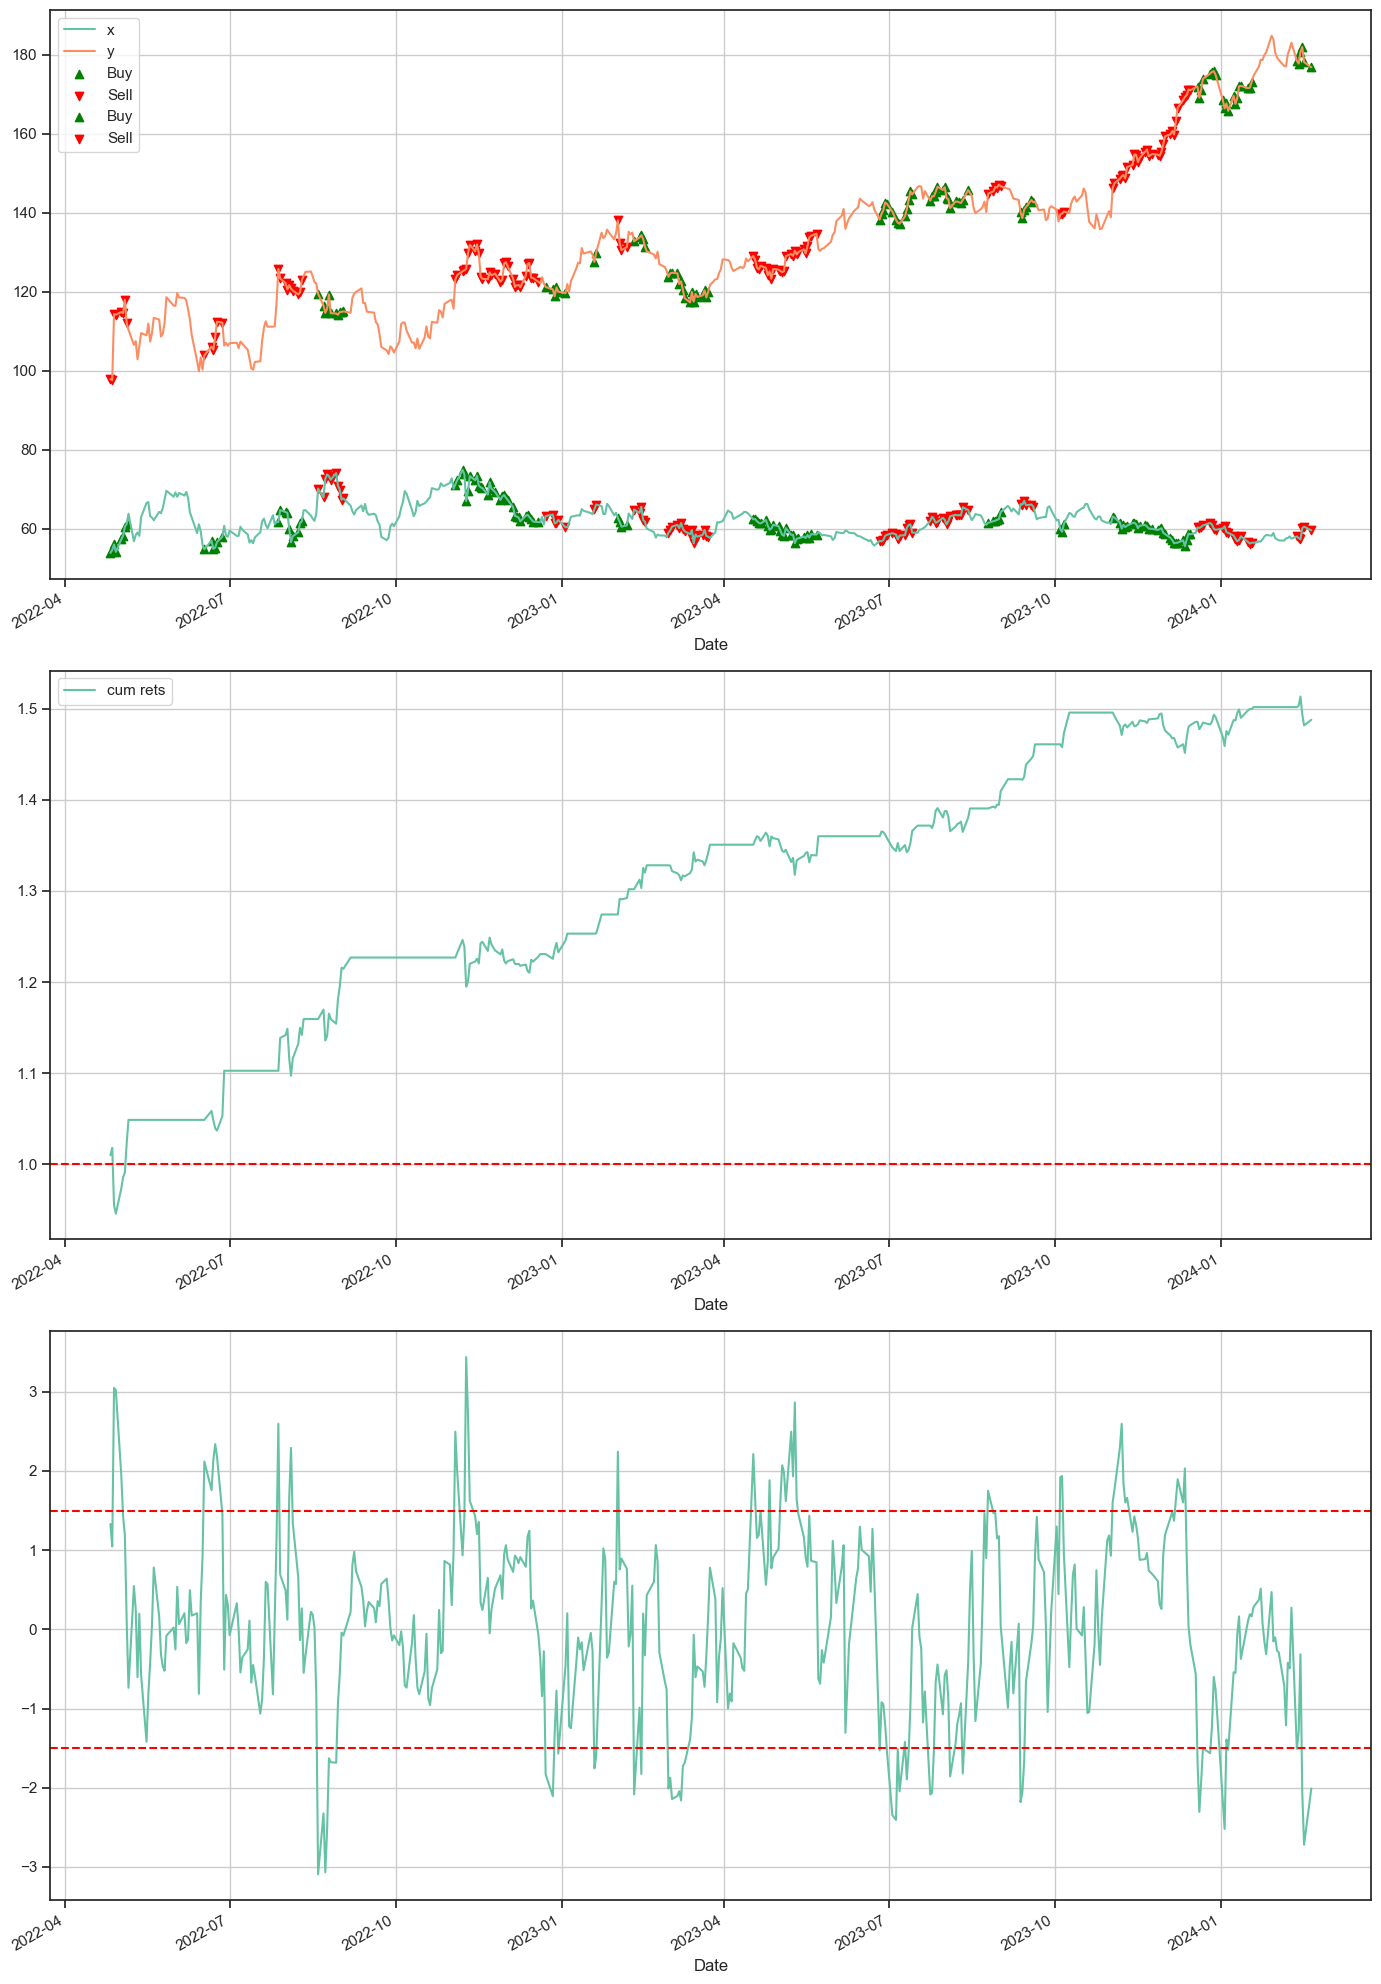

In [8]:
axes_tuple = kalman.py_plot(ib_processor.df,date,ib_processor.first_inst,ib_processor.second_inst,is_close = False)

In [9]:
#empty_df = pd.DataFrame([],columns = ['first_stock','first_quantity','second_stock','second_quantity','Hedge Ratio'])
#empty_df.to_csv('trades/holding_pairs.csv',index = False, header = True)